In [2]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [3]:
with open('distort_calibration.pickle', 'rb') as f:
    dist_info = pickle.load(f)

In [4]:
def undistort(img, dist_info):
    return cv2.undistort(img, dist_info['mtx'], dist_info['dist'], None, dist_info['mtx'])

In [5]:
images = glob.glob('test_images/*')

In [6]:
images

['test_images/test4.jpg',
 'test_images/test1.jpg',
 'test_images/straight_lines1.jpg',
 'test_images/test6.jpg',
 'test_images/test5.jpg',
 'test_images/test3.jpg',
 'test_images/test2.jpg',
 'test_images/straight_lines2.jpg']

In [93]:
def abs_sobel(img, orient='x', sobel_kernel=9):
    """ img should already be grayscale """
    ret = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1*(orient=='x'), 1*(orient=='y'), ksize=sobel_kernel))
    return ret

def sobel_magnitude(sx, sy, wx=1, wy=1):
    return np.sqrt(wx*sx**2+wy*sy**2)

def sobel_magnitude_thresh(sx, sy, wx=1, wy=1, thresh=(0.3,1)):
    mag = sobel_magnitude(sx, sy, wx, wy)
    mag = mag/np.max(mag)
    ret = np.zeros_like(mag)
    ret[(mag>=thresh[0]) & (mag<=thresh[1])] = 1
    return ret

def sobel_direction_thresh(sx, sy, thresh=(np.pi/6, np.pi/6*2.5)):
    dr = np.arctan2(sy, sx)
    ret = np.zeros_like(dr)
    ret[(dr>=thresh[0]) & (dr<=thresh[1])] = 1
    return ret

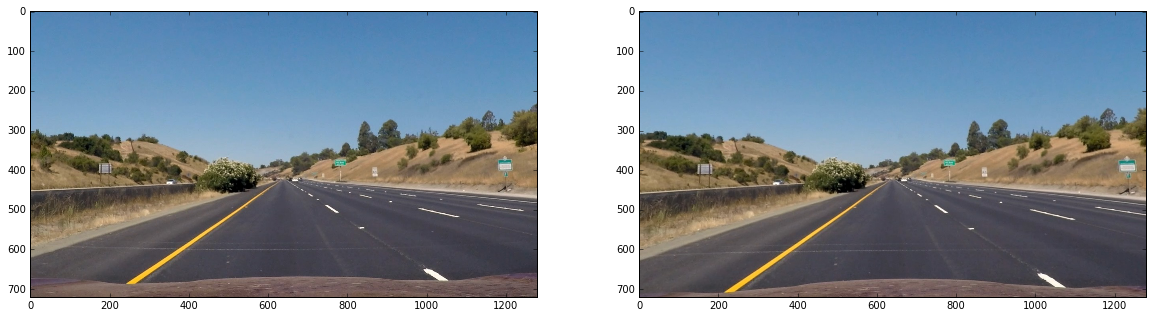

In [113]:
img = cv2.imread(images[2])
img_ud = undistort(img, dist_info)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(img_ud[:,:,::-1])

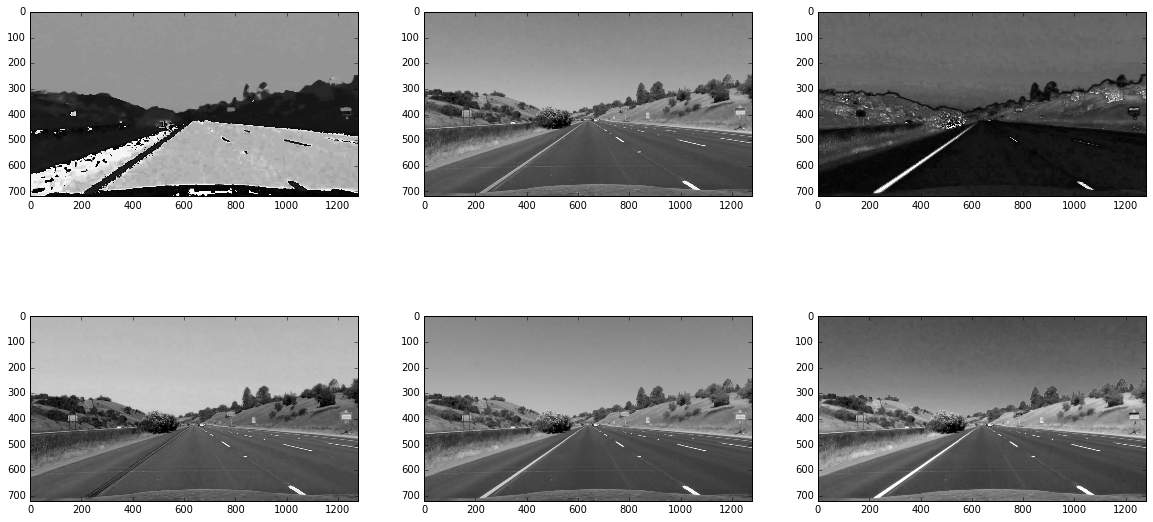

In [114]:
gray = cv2.cvtColor(img_ud, cv2.COLOR_BGR2GRAY)
hls = cv2.cvtColor(img_ud, cv2.COLOR_BGR2HLS)
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(hls[:,:,i], cmap='gray')
for i in range(3):
    plt.subplot(2,3,i+4)
    plt.imshow(img_ud[:,:,i], cmap='gray')


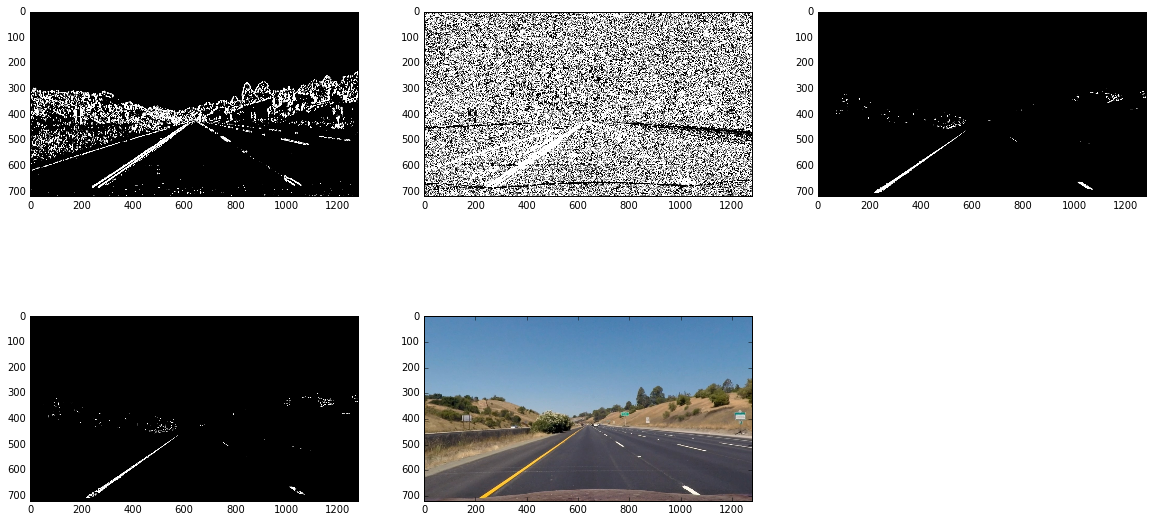

In [115]:
gray = img[:,:,-1]
sobel_x = abs_sobel(gray, orient='x')
sobel_y = abs_sobel(gray, orient='y')
sobel_rel_mag = sobel_magnitude_thresh(sobel_x, sobel_y, wy=0, thresh=(0.06,1))
sobel_dir = sobel_direction_thresh(sobel_x, sobel_y, thresh=(np.pi/9, np.pi/2*0.9))
s_channel = hls[:,:,2]
s_channel = (s_channel>160)
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(255*sobel_rel_mag, cmap='gray')
plt.subplot(2,3,2)
plt.imshow(255*sobel_dir, cmap='gray')
plt.subplot(2,3,3)
plt.imshow(255*s_channel, cmap='gray')
plt.subplot(2,3,4)
plt.imshow((255*((s_channel+sobel_rel_mag*0.5+sobel_dir*0.5)>=1.5)).astype(np.uint8), cmap='gray')
plt.subplot(2,3,5)
plt.imshow(img_ud[:,:,::-1])

255


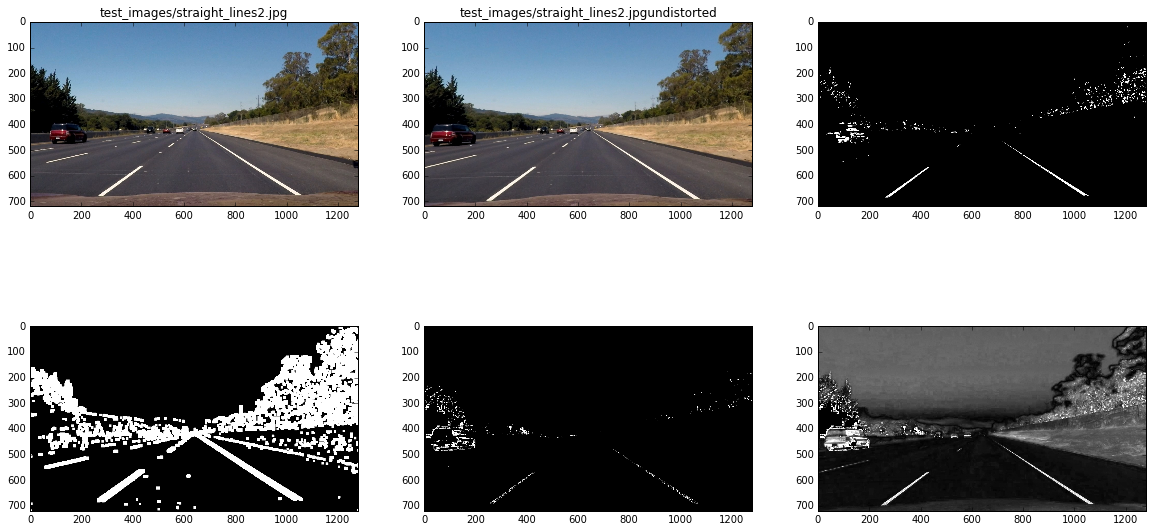

In [278]:
f = images[7]
img = cv2.imread(f)
img_ud = undistort(img, dist_info)
img_size = (img_ud.shape[1], img_ud.shape[0])
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(img[:,:,::-1])
plt.title(f)
plt.subplot(2,3,2)
plt.imshow(img_ud[:,:,::-1])
plt.title(f + 'undistorted')
hls = cv2.cvtColor(img_ud, cv2.COLOR_BGR2HLS)
gray = img[:,:,-1]
sobel_x = abs_sobel(gray, orient='x')
sobel_y = abs_sobel(gray, orient='y')
sobel_rel_mag = sobel_magnitude_thresh(sobel_x, sobel_y, wy=0, thresh=(0.1,1))
sobel_rel_mag = np.clip(cv2.filter2D(sobel_rel_mag,-1,np.ones((9,9))),0,1)
sobel_dir = sobel_direction_thresh(sobel_x, sobel_y, thresh=(np.pi/9, np.pi/2*0.9))
s_channel = hls[:,:,2]
print(np.max(s_channel))
plt.subplot(2,3,3)
plt.imshow((255*(((s_channel/np.max(s_channel)*1.6)>=1)*sobel_rel_mag).astype(np.uint8)), cmap='gray')
plt.subplot(2,3,4)
plt.imshow(255*sobel_rel_mag, cmap='gray')
plt.subplot(2,3,5)
plt.imshow(255*(s_channel/255.).astype(np.uint8), cmap='gray')
plt.subplot(2,3,6)
plt.imshow(s_channel, cmap='gray')

res = 255*(((s_channel/np.max(s_channel)*1.6)>=1)*sobel_rel_mag).astype(np.uint8)

In [282]:
pp_src = np.array([(200,720-36),(1120,720-36),(580,720-268),(705,720-268)]).astype(np.float32)
pp_dst = np.array([(320,720),(860,720),(320,0),(860,0)]).astype(np.float32)
pp_mtx = cv2.getPerspectiveTransform(pp_src, pp_dst)

In [283]:
img_pp = cv2.warpPerspective(res, pp_mtx, img_size)

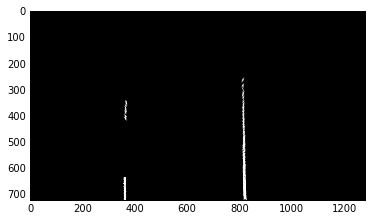

In [284]:
plt.imshow(img_pp[:,:], cmap='gray')